In [1]:
import os
import zipfile
import datetime
from collections import Counter

import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model


import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt

# Dataset

## Data visualization

Normal chest x-ray


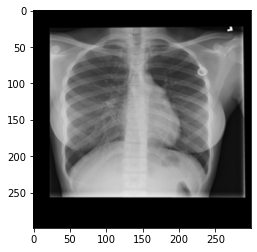

Covid chest x-ray


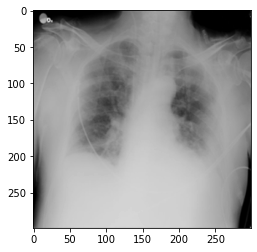

Lung_Opacity x-ray


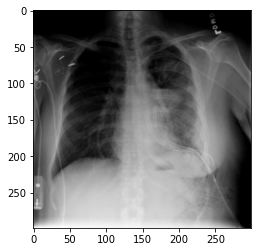

Viral Pneumonia chest x-ray


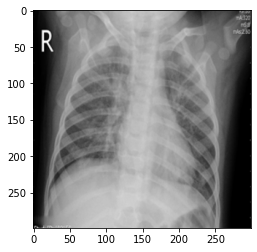

In [16]:
img_path = 'D:/Machine Learning_Deep Learning/archive (1)/COVID-19_Radiography_Dataset/'
covid_imgs = os.listdir(img_path+'/COVID')
normal_imgs = os.listdir(img_path+'/Normal')
lungop_imgs = os.listdir(img_path + '/Lung_Opacity')
pneumonia_imgs = os.listdir(img_path + '/Viral Pneumonia')

print("Normal chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'Normal',normal_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()

print("Covid chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'COVID',covid_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()

print("Lung_Opacity x-ray")
im = PIL.Image.open(os.path.join(img_path,'Lung_Opacity',lungop_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()

print("Viral Pneumonia chest x-ray")
im = PIL.Image.open(os.path.join(img_path,'Viral Pneumonia',pneumonia_imgs[0]))
plt.imshow(im,cmap="gray")
plt.show()


## Image pre-processing and train-test split

In [4]:
BATCH_SIZE = 20
IMAGE_SIZE = 224
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)

In [5]:
list_files = []
for dir in os.listdir(img_path):
  aux_dir = os.path.join(img_path,dir)
  
  if os.path.isdir(aux_dir):
    for img in os.listdir(aux_dir):
      list_files.append([os.path.join(dir,img),dir])
df = pd.DataFrame(list_files, columns=['id','label'])
df.describe()

,id,label
count,21165,21165
unique,21165,4
top,Lung_Opacity\Lung_Opacity-4656.png,Normal
freq,1,10192


In [6]:
def frequency_plot(df):
  freq_abs = Counter(df.label);
  freq_a = pd.DataFrame.from_dict(freq_abs, orient='index').reset_index()
  total = len(df.index)
  freq_r = freq_a[0]/total
  freq_a[1] = freq_r
  freq_a.columns = ['Label','Absolute Frequency','Relative Frequency']
  return freq_a
frequency_plot(df)

,Label,Absolute Frequency,Relative Frequency
0,COVID,3616,0.170848
1,Lung_Opacity,6012,0.284054
2,Normal,10192,0.481550
3,Viral Pneumonia,1345,0.063548


## Undersampling classes

O conjunto de dados está desequilibrado. Como nosso foco é a classe COVID, iremos subamostrar as classes com mais exemplos do que a classe COVID e manter as classes com menos exemplos.

**English**

The dataset is unbalanced. As our focus is the COVID class, we will undersample classes with more examples than the COVID class and keep classes with less examples.

In [7]:
def balance_dataset(focus_class, df):
  classes = df.label.unique()
  classes_df_list = []
  focus_class_df = df[df.label == focus_class]
  classes_df_list.append(focus_class_df)
  count_focus_class = len(focus_class_df)
  ##Divide by class
  for classe in classes:
    class_df = df[df.label == classe]
    count_class = len(class_df)
    if classe == focus_class:
      continue
    if count_class > count_focus_class+1000:
      class_df = class_df.sample(count_focus_class+1000)
    classes_df_list.append(class_df)
  df_under = pd.concat(classes_df_list, axis=0) 
  return df_under


df = balance_dataset('COVID',df)

frequency_plot(df)

,Label,Absolute Frequency,Relative Frequency
0,COVID,3616,0.254773
1,Lung_Opacity,4616,0.325231
2,Normal,4616,0.325231
3,Viral Pneumonia,1345,0.094765


In [8]:
def split_dataset(df,test_size,random_state = 101):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
  df = df.reset_index()
  for train_index, test_index in sss.split(df['id'], df['label']):
    X_train, X_test = df['id'][train_index], df['id'][test_index]
    y_train, y_test = df['label'][train_index], df['label'][test_index]
  traindf = pd.concat([X_train, y_train], axis=1)
  testdf = pd.concat([X_test, y_test], axis=1)
  return traindf,testdf

#divide train/val/test in 80/10/10
traindf,testdf = split_dataset(df,test_size = 0.25)
valdf,testdf= split_dataset(testdf,test_size = 0.50)
# traindf = balance_dataset('COVID',df)


traindf.id = img_path + traindf.id
valdf.id = img_path + valdf.id
testdf.id = img_path + testdf.id

In [9]:
frequency_plot(traindf)

,Label,Absolute Frequency,Relative Frequency
0,COVID,2712,0.254791
1,Lung_Opacity,3462,0.325254
2,Viral Pneumonia,1008,0.094701
3,Normal,3462,0.325254


In [10]:
frequency_plot(valdf)

,Label,Absolute Frequency,Relative Frequency
0,COVID,452,0.254791
1,Lung_Opacity,577,0.325254
2,Viral Pneumonia,168,0.094701
3,Normal,577,0.325254


In [11]:
frequency_plot(testdf)

,Label,Absolute Frequency,Relative Frequency
0,Normal,577,0.325070
1,Lung_Opacity,577,0.325070
2,COVID,452,0.254648
3,Viral Pneumonia,169,0.095211


## Image Data Generator

In [12]:
BATCH_SIZE = 20
IMAGE_SIZE = 224
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)

In [13]:
BATCH_SIZE=50

"""
train_datagen = ImageDataGenerator(          
    rotation_range = 40,
    width_shift_range = 0.2,
  height_shift_range=0.2,
  shear_range = 0.2,
  zoom_range = 0.1,
  fill_mode = 'nearest',
)
"""
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


print("Creating train generator...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)


val_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    color_mode="rgb",
    seed=5,
    shuffle = False,
    batch_size=30,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

print("\nCreating val generator...")
val_generator = val_datagen.flow_from_dataframe(
    dataframe=valdf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    batch_size=5,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)




Creating train generator...
Found 10644 validated image filenames belonging to 4 classes.
Found 1775 validated image filenames belonging to 4 classes.

Creating val generator...
Found 1774 validated image filenames belonging to 4 classes.


## Importing VGG16 model

In [15]:
from keras.applications.vgg16 import VGG16
base_convnet = VGG16(include_top=False, input_shape=input_shape,
                     weights='imagenet')


#Freeze base convolutional layers
base_convnet.trainable = False
base_convnet.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Addition of fully connected layers

In [16]:
model = models.Sequential()
model.add(base_convnet)

"""
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, 3,padding='same',activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(256, 3,padding='same',activation='relu'))
model.add(layers.Dropout(0.30))
"""

# model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(4, activation='softmax',name="fc_out"))

model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
fc_out (Dense)               (None, 4)                 4


## Training the classification model

In [24]:
checkpoints_path = '/kaggle/output/models_checkpoints/covid_project'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoints_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
#to avoid overfitting
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=7)
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [25]:
EPOCHS = 50
LEARNING_RATE = 1e-5
DECAY= LEARNING_RATE/EPOCHS
model.compile(
    loss='categorical_crossentropy',
    # optimizer = tf.keras.optimizers.RMSprop(lr=2e-5),
     optimizer = tf.keras.optimizers.Nadam(lr=LEARNING_RATE),
    metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision(),
             'acc']
)

callbacks = [model_checkpoint_callback,early,mcp_save]
history1 = model.fit_generator(
    train_generator,
    steps_per_epoch = BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data = val_generator,
    validation_steps=BATCH_SIZE,
    verbose=1
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
50/50 [==============================] - 100s 2s/step - loss: 1.1879 - recall: 0.2128 - precision: 0.6122 - acc: 0.4756 - val_loss: 0.9460 - val_recall: 0.3440 - val_precision: 0.8037 - val_acc: 0.6640
Epoch 2/50
50/50 [==============================] - 116s 2s/step - loss: 0.9214 - recall: 0.4268 - precision: 0.7288 - acc: 0.6216 - val_loss: 0.7426 - val_recall: 0.5680 - val_precision: 0.7933 - val_acc: 0.7160
Epoch 3/50
50/50 [==============================] - 108s 2s/step - loss: 0.7466 - recall: 0.5764 - precision: 0.7957 - acc: 0.7144 - val_loss: 0.7185 - val_recall: 0.6120 - val_precision: 0.8010 - val_acc: 0.7200
Epoch 4/50
50/50 [==============================] - 97s 2s/step - loss: 0.6852 - recall: 0.6460 - precision: 0.8063 - acc: 0.7552 - val_loss: 0.5569 - val_recall: 0.7160 - val_precision: 0.8689 - val_acc: 0.8000
Epoch 5/50
50/50 [==============================] - 88s 2s/step - loss: 0

In [27]:
callbacks = [model_checkpoint_callback,early,mcp_save]


## Fine-tuning

<p> Será realizado um fine tuning no modelo, descongelando as camadas do vgg16 e treinando <\p>
    
**English**
    
<p> The model will be fine tuned, unfreezing the vgg16 layers and training <\p>

In [28]:
base_convnet.trainable= True
EPOCHS = 50

history2 = model.fit_generator(
    train_generator,
    steps_per_epoch = BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data = val_generator,
    validation_steps=BATCH_SIZE,
    verbose=1
)

Epoch 1/50
50/50 [==============================] - 23s 459ms/step - loss: 0.2087 - recall: 0.9204 - precision: 0.9357 - acc: 0.9296 - val_loss: 0.2887 - val_recall: 0.9080 - val_precision: 0.9228 - val_acc: 0.9200
Epoch 2/50
50/50 [==============================] - 22s 447ms/step - loss: 0.2149 - recall: 0.9148 - precision: 0.9316 - acc: 0.9240 - val_loss: 0.2963 - val_recall: 0.8840 - val_precision: 0.8984 - val_acc: 0.9000
Epoch 3/50
50/50 [==============================] - 23s 463ms/step - loss: 0.2156 - recall: 0.9200 - precision: 0.9353 - acc: 0.9292 - val_loss: 0.2454 - val_recall: 0.9160 - val_precision: 0.9197 - val_acc: 0.9200
Epoch 4/50
50/50 [==============================] - 22s 450ms/step - loss: 0.2232 - recall: 0.9116 - precision: 0.9306 - acc: 0.9228 - val_loss: 0.2747 - val_recall: 0.9000 - val_precision: 0.9146 - val_acc: 0.9120
Epoch 5/50
50/50 [==============================] - 24s 478ms/step - loss: 0.2136 - recall: 0.9136 - precision: 0.9319 - acc: 0.9244 - val_l

In [30]:
vgg16_model = model

# Evaluate Model

In [31]:
vgg16_model.evaluate(test_generator)

60/60 [==============================] - 62s 1s/step - loss: 0.2599 - recall: 0.9048 - precision: 0.9156 - acc: 0.9104


[0.2598646879196167,
 0.9047887325286865,
 0.9156214594841003,
 0.9104225635528564]

In [32]:
from sklearn.metrics import classification_report

test_pred_raw = vgg16_model.predict(test_generator)
test_labels = np.asarray(test_generator.classes)
test_pred = np.argmax(test_pred_raw, axis=1)

class_names = list(test_generator.class_indices.keys())
print(classification_report(test_labels, test_pred))
print(test_generator.class_indices)


              precision    recall  f1-score   support

           0       0.94      0.96      0.95       452
           1       0.90      0.88      0.89       577
           2       0.88      0.89      0.88       577
           3       0.95      0.97      0.96       169

    accuracy                           0.91      1775
   macro avg       0.92      0.92      0.92      1775
weighted avg       0.91      0.91      0.91      1775

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


### confusion matrix code

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    


    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
      cm = cm / np.expand_dims(cm.sum(axis=1),axis=1)
        # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      pass

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Confusion Matrix

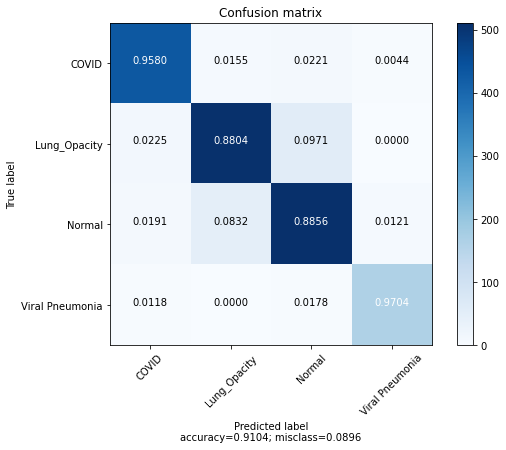

In [34]:
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
plot_confusion_matrix(cm,class_names)